In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms 
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2
import sys
import json

### Todo:
- Fix Directories, and corresponding model name updates
- Save Model Weights Pytorch to use for Face Detection

In [17]:
def return_labeled_data_color():
    TARGET_NO_MASK_DIR="../images_color_transformed_no_mask"
    TARGET_MASK_DIR="../images_color_transformed_mask"
    # no mask
    data_list = []
    target_list = []
    for filename in os.listdir(TARGET_NO_MASK_DIR):
        img = cv2.imread(f'{TARGET_NO_MASK_DIR}/{filename}')
        data_list.append(img)
        target_list.append(0.0)
        
    # mask
    for filename in os.listdir(TARGET_MASK_DIR):
        img = cv2.imread(f'{TARGET_MASK_DIR}/{filename}')
        data_list.append(img)
        target_list.append(1.0)
    return data_list, target_list

In [18]:
def return_labeled_data_gray():
    TARGET_NO_MASK_DIR="../images_gray_transformed_no_mask"
    TARGET_MASK_DIR="../images_gray_transformed_mask"
    # no mask
    data_list = []
    target_list = []
    for filename in os.listdir(TARGET_NO_MASK_DIR):
        img = cv2.imread(f'{TARGET_NO_MASK_DIR}/{filename}', cv2.IMREAD_GRAYSCALE)
        data_list.append(img)
        target_list.append(0.0)
        
    # mask
    for filename in os.listdir(TARGET_MASK_DIR):
        img = cv2.imread(f'{TARGET_MASK_DIR}/{filename}', cv2.IMREAD_GRAYSCALE)
        data_list.append(img)
        target_list.append(1.0)
    return data_list, target_list

In [19]:
data_raw, target_raw = return_labeled_data_gray()

In [28]:
data_raw, target_raw = return_labeled_data_color()

In [20]:
class MaskDataSet(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = torch.tensor(y)
        self.n = len(self.y)
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.X[index], self.y[index]
        if self.transform:
            x = self.transform(x)
        return x,y
            
    def __len__(self):
        return self.n

img_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0), (1))])
dataset = MaskDataSet(data_raw, target_raw, transform=img_transform)

In [21]:
BATCH_SIZE = 20

In [22]:
total_idxs = np.random.permutation(np.arange(0, len(dataset), 1))
split_val_idx = int(np.floor(len(total_idxs)*0.7))
split_test_idx = int(np.floor(len(total_idxs)*0.8))
train_idxs, val_idxs, test_idxs = total_idxs[:split_val_idx], total_idxs[split_val_idx:split_test_idx], total_idxs[split_test_idx:]

train_sampler = SubsetRandomSampler(train_idxs)
val_sampler = SubsetRandomSampler(val_idxs)
test_sampler = SubsetRandomSampler(test_idxs)

train_load = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
val_load = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, sampler=val_sampler)
test_load = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, sampler=test_sampler, shuffle=False)

In [23]:
def sigmoid(x):
    return torch.exp(x)/(1+torch.exp(x))

class MaskCNNGray(nn.Module):
    def __init__(self, N):
        super(MaskCNNGray, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3)
        #self.conv1 = nn.Conv2d(1, 8, 3)
        #self.conv2 = nn.Conv2d(8, 16, 3)
        self.pool = nn.MaxPool2d(2,2)
        self.linear1 = nn.Linear(8*16*16, 256)
        #self.linear1 = nn.Linear(16*7*7, 256)
        self.linear2 = nn.Linear(256, 1)
        
    def forward(self, x):
        out = self.pool(F.relu(self.conv1(x)))
        #out = self.pool(F.relu(self.conv1(x)))
        #out = self.pool(F.relu(self.conv2(out)))
        out = out.view(-1, 8*16*16)
        #out = out.view(-1, 16*7*7)
        out = F.relu(self.linear1(out))
        return sigmoid(self.linear2(out))

In [24]:
class MaskCNNColor(nn.Module):
    def __init__(self, N):
        super(MaskCNNColor, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3)
        #self.conv1 = nn.Conv2d(1, 8, 3)
        #self.conv2 = nn.Conv2d(8, 16, 3)
        self.pool = nn.MaxPool2d(2,2)
        self.linear1 = nn.Linear(8*16*16, 256)
        #self.linear1 = nn.Linear(16*7*7, 256)
        self.linear2 = nn.Linear(256, 1)
        
    def forward(self, x):
        out = self.pool(F.relu(self.conv1(x)))
        #out = self.pool(F.relu(self.conv1(x)))
        #out = self.pool(F.relu(self.conv2(out)))
        out = out.view(-1, 8*16*16)
        #out = out.view(-1, 16*7*7)
        out = F.relu(self.linear1(out))
        return sigmoid(self.linear2(out))

In [25]:
# Seems that the data is linearly seperable!!
class Perceptron(nn.Module):
    def __init__(self):
        super(Perceptron, self).__init__()
        self.linear1 = nn.Linear(34*34, 256)
        self.linear2 = nn.Linear(256, 1)
        
    def forward(self, x):
        out = x.view(-1, 34*34)
        out = self.linear1(out)
        return F.sigmoid(self.linear2(out))
    

In [35]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [39]:
EPOCHS = 100
IMAGE_DIM = 34
model = MaskCNNGray(IMAGE_DIM)
# model = MaskCNNColor(IMAGE_DIM)
# model = Perceptron()
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [40]:
# train loop
train_loss = []
val_loss = []
val_loss_min = sys.maxsize

for epoch in range(EPOCHS):
    training_loss = 0
    train_size = 0
    validation_loss = 0
    validation_size = 0
    
    model.train()
    for images, labels in train_load:
#         images, labels = images.to(device), labels.to(device)
        # train
        labels = labels.view(len(labels), -1)
        optimizer.zero_grad()
        out = model.forward(images)

        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        training_loss += loss
        train_size += len(images)
        # .item()
    
    model.eval()
    for images, labels in val_load:
        # images, labels = images.to(device), labels.to(device)
        labels = labels.view(len(labels), -1)
        optimizer.zero_grad()
        out = model.forward(images)
        loss = criterion(out, labels)
        validation_loss += loss
        validation_size += len(images)
        # .item()
    
    t_loss = training_loss
    v_loss = validation_loss
    train_loss.append(t_loss.item())
    val_loss.append(v_loss.item())
    
    print(f"EPOCH:{epoch} - Training Loss: {t_loss} - Validation Loss: {v_loss}")
    if v_loss < val_loss_min:
        print(f"Validation Loss Decreased From {val_loss_min} => {v_loss}")
        val_loss_min = v_loss

EPOCH:0 - Training Loss: 10.343568801879883 - Validation Loss: 2.073237180709839
Validation Loss Decreased From 9223372036854775807 => 2.073237180709839
EPOCH:1 - Training Loss: 10.250484466552734 - Validation Loss: 2.0523040294647217
Validation Loss Decreased From 2.073237180709839 => 2.0523040294647217
EPOCH:2 - Training Loss: 10.157368659973145 - Validation Loss: 1.994253158569336
Validation Loss Decreased From 2.0523040294647217 => 1.994253158569336
EPOCH:3 - Training Loss: 10.066155433654785 - Validation Loss: 1.968820571899414
Validation Loss Decreased From 1.994253158569336 => 1.968820571899414
EPOCH:4 - Training Loss: 9.986722946166992 - Validation Loss: 2.0577950477600098
EPOCH:5 - Training Loss: 9.881986618041992 - Validation Loss: 2.058774948120117
EPOCH:6 - Training Loss: 9.712321281433105 - Validation Loss: 2.030158281326294
EPOCH:7 - Training Loss: 9.564886093139648 - Validation Loss: 1.8144593238830566
Validation Loss Decreased From 1.968820571899414 => 1.814459323883056

EPOCH:80 - Training Loss: 0.5281020402908325 - Validation Loss: 0.7442758083343506
EPOCH:81 - Training Loss: 0.5016749501228333 - Validation Loss: 0.14842751622200012
Validation Loss Decreased From 0.1703324317932129 => 0.14842751622200012
EPOCH:82 - Training Loss: 0.4574525058269501 - Validation Loss: 0.2233348786830902
EPOCH:83 - Training Loss: 0.43618643283843994 - Validation Loss: 0.19917504489421844
EPOCH:84 - Training Loss: 0.42974385619163513 - Validation Loss: 0.23950441181659698
EPOCH:85 - Training Loss: 0.4066448509693146 - Validation Loss: 0.1916821151971817
EPOCH:86 - Training Loss: 0.4107075035572052 - Validation Loss: 0.23943226039409637
EPOCH:87 - Training Loss: 0.4024044871330261 - Validation Loss: 0.33574584126472473
EPOCH:88 - Training Loss: 0.4842630624771118 - Validation Loss: 0.1340702921152115
Validation Loss Decreased From 0.14842751622200012 => 0.1340702921152115
EPOCH:89 - Training Loss: 0.42792826890945435 - Validation Loss: 0.21537376940250397
EPOCH:90 - Trai

In [41]:
with open('gray_train_loss.json', 'w') as file:
    json.dump(train_loss, file)
with open('gray_val_loss.json', 'w') as file:
    json.dump(val_loss, file)

In [42]:
with open('gray_train_loss.json', 'r') as file:
    train_loss = json.load(file)
with open('gray_val_loss.json', 'r') as file:
    val_loss = json.load(file)

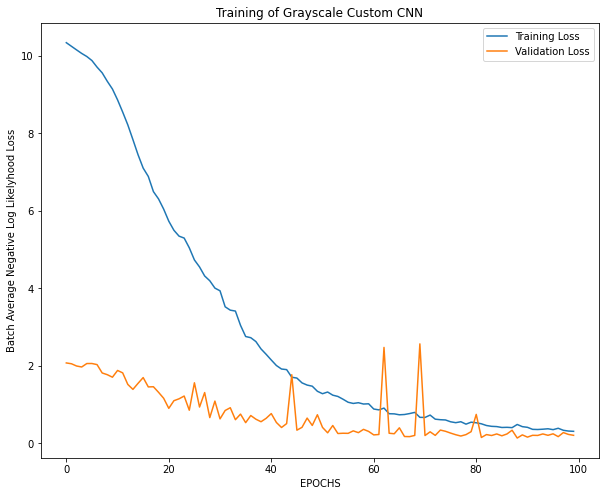

In [43]:
fig = plt.figure(figsize=(10,8))
n = np.arange(0, len(train_loss),1 )
plt.plot(n, train_loss, label="Training Loss")
plt.plot(n, val_loss, label="Validation Loss")
plt.title("Training of Grayscale Custom CNN")
plt.xlabel("EPOCHS")
plt.ylabel("Batch Average Negative Log Likelyhood Loss")
plt.legend()
plt.savefig('graytraining.png')
plt.show()


In [36]:
with open('color_train_loss.json', 'w') as file:
    json.dump(train_loss, file)
with open('color_val_loss.json', 'w') as file:
    json.dump(val_loss, file)

In [37]:
with open('color_train_loss.json', 'r') as file:
    train_loss = json.load(file)
with open('color_val_loss.json', 'r') as file:
    val_loss = json.load(file)

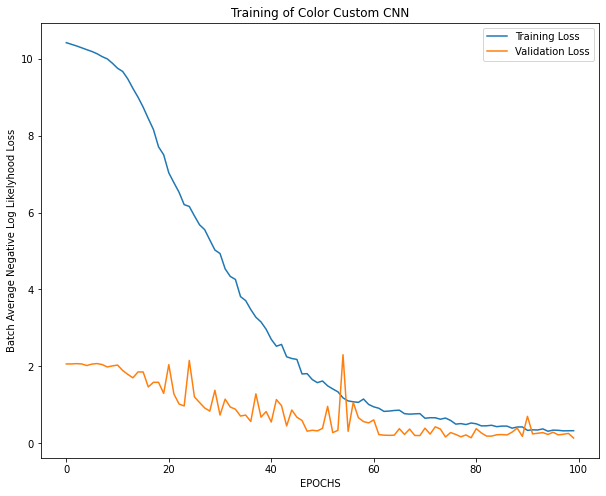

In [38]:
fig = plt.figure(figsize=(10,8))
n = np.arange(0, len(train_loss),1 )
plt.plot(n, train_loss, label="Training Loss")
plt.plot(n, val_loss, label="Validation Loss")
plt.title("Training of Color Custom CNN")
plt.xlabel("EPOCHS")
plt.ylabel("Batch Average Negative Log Likelyhood Loss")
plt.legend()
plt.savefig('colortraining.png')
plt.show()


In [16]:
# test loop
n_samples = 0
n_correct = 0
classified_correct = []
classified_incorrect = []
confusion_matrix = np.zeros((2,2))

model.eval()
for images, labels in test_load:
#     images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    preds = torch.round(model(images))
    preds, labels = preds.detach().numpy(), labels.detach().numpy()
    n_samples += len(preds)
    n_correct += len((preds == labels))
    # .item()
    for i in range(2):
        idxs = np.arange(0, len(preds), 1)[labels==i]
        for ind in idxs:
            confusion_matrix[i][int(preds[ind])] += 1
            if preds[ind] == i:
                classified_correct.append([images[ind], preds[ind]])
            else:
                classified_incorrect.append([images[ind], preds[ind]])

In [17]:
print(f"Model Accuracy: {(n_correct/n_samples)*100}")

Model Accuracy: 100.0


In [18]:
print(confusion_matrix)

[[36.  0.]
 [ 2. 44.]]


In [17]:
def predict(model, img):
    copy = img.copy()
    model.eval()
    optimizer.zero_grad()
    trans = img_transform(img)
    trans = trans.view(-1, *list(trans.shape))
    out = torch.round(model.forward(trans))
    pred = 'No Mask' if out == 0 else 'Mask'
    print(pred)
    plot_image(copy)

In [18]:
def plot_image(img):
    fig = plt.figure(figsize=(10,8))
    plt.imshow(img, cmap='gray')
    plt.show()

In [ ]:
predict(model, data_raw[154])

Mask


No Mask


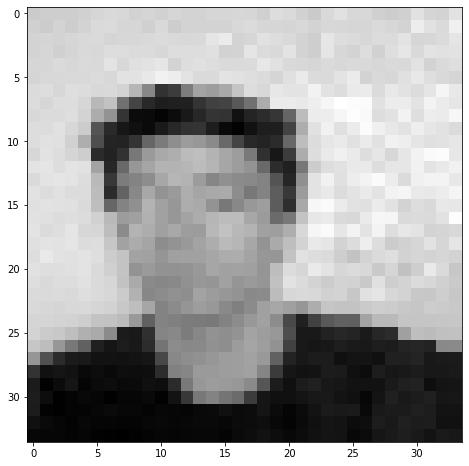

In [111]:
predict(model, data_raw[45])

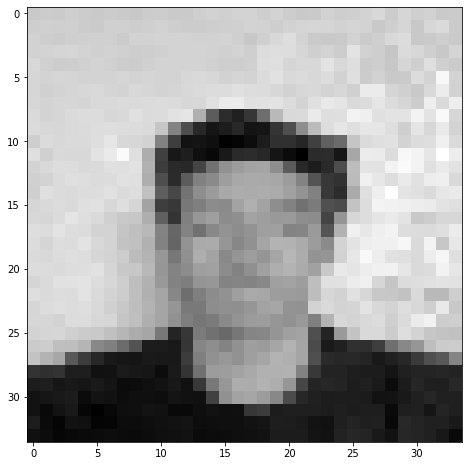

In [101]:
img = cv2.imread('../images_transformed_no_mask/IMG_5459.JPG', cv2.IMREAD_GRAYSCALE)
plot_image(data_raw[0])

In [67]:
print(len(model.conv1.weight.data))
print(len(model.conv1.weight.data[0]))
model.conv1.weight[1]

8
1


tensor([[[-0.2837,  0.2935, -0.0133],
         [ 0.3113,  0.1019, -0.0353],
         [-0.0517,  0.2620, -0.1692]]], grad_fn=<SelectBackward>)

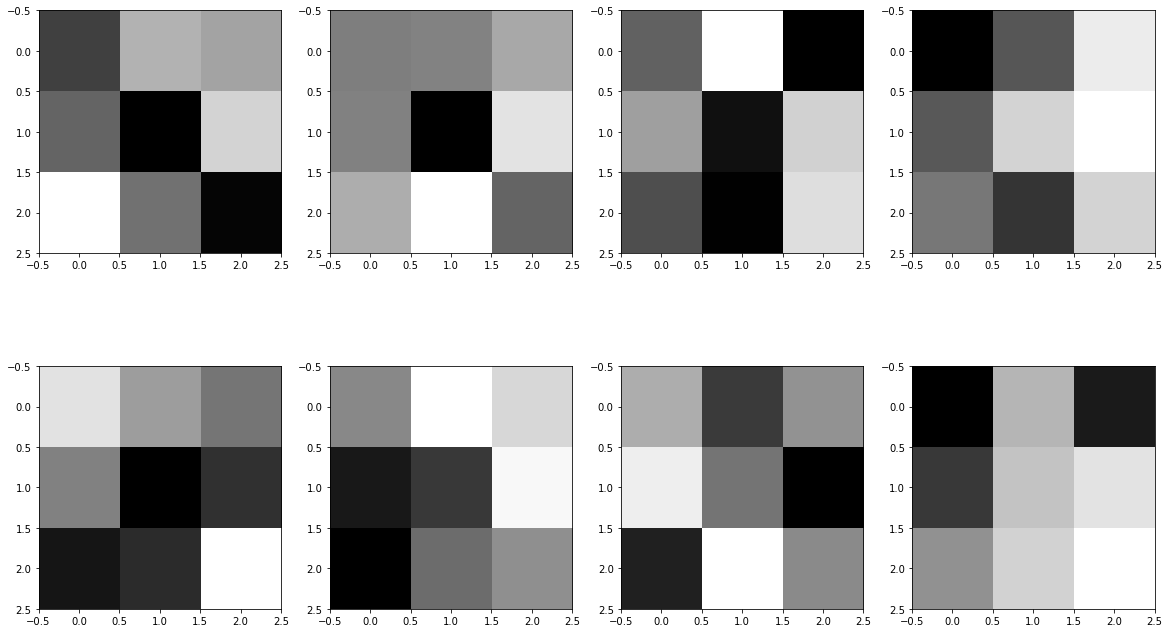

In [102]:
weights = []
for i in range(len(model.conv1.weight)):
    weights.append(model.conv1.weight[i].detach().numpy()[0])
    
fig,axes = plt.subplots(2,4,figsize=(20,12))
for i in range(2):
    for j in range(4):
        axes[i][j].imshow(weights[i*4+j], cmap='gray')

In [105]:
model.conv1.weight.size()

torch.Size([8, 1, 3, 3])

In [109]:
conv = torch.nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3)
conv.weight[0]

tensor([[[ 0.1202,  0.0051,  0.0896],
         [-0.0962, -0.1641, -0.1042],
         [-0.1279, -0.0388, -0.0045]],

        [[-0.1555,  0.0769, -0.0680],
         [-0.1267,  0.1332,  0.0185],
         [-0.0210,  0.0263, -0.0617]],

        [[ 0.1516, -0.0848, -0.0999],
         [-0.0375,  0.0147,  0.0569],
         [-0.1516, -0.1696, -0.0421]]], grad_fn=<SelectBackward>)